In [1]:
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import os

In [2]:
base_dir="/content/drive/MyDrive/TESS Toronto emotional speech set data"

In [3]:
def extract_features(file_path):
    # Load audio file
    y, sr = librosa.load(file_path)

    # Extract features
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_stft_mean = np.mean(chroma_stft, axis=1)

    fft = np.fft.fft(y)
    fft_mean = np.mean(np.abs(fft))

    mfccs = librosa.feature.mfcc(y=y, sr=sr)
    mfccs_mean = np.mean(mfccs, axis=1)

    spectrogram = librosa.amplitude_to_db(librosa.stft(y))
    spectrogram_mean = np.mean(spectrogram, axis=1)

    # Concatenate features
    features = np.concatenate((chroma_stft_mean, [fft_mean], mfccs_mean, spectrogram_mean))

    return  chroma_stft,fft_mean,mfccs_mean,spectrogram_mean

In [4]:
data =[]

In [5]:
for class_dir in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_dir)
    if os.path.isdir(class_path):
        # Loop through each audio file in the class directory
        for file_name in os.listdir(class_path):
            if file_name.endswith('.wav'):
                file_path = os.path.join(class_path, file_name)
                chroma_stft,fft_mean,mfccs_mean,spectrogram_mean = extract_features(file_path)
                # Combine the file name, class, and features into one row
                row = [file_name, class_dir, chroma_stft,fft_mean,mfccs_mean,spectrogram_mean]
                data.append(row)

<ipython-input-3-d9b3f246c7a3>:15: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  spectrogram = librosa.amplitude_to_db(librosa.stft(y))


In [6]:
columns = ['file_name', 'class','chroma_stft_mean', 'fft_mean', 'mfccs_mean', 'spectrogram_mean']
df = pd.DataFrame(data, columns=columns)

In [7]:
for col in ['mfccs_mean', 'chroma_stft_mean', 'spectrogram_mean']:
    df[col] = df[col].apply(lambda x: np.array(x).flatten())

In [8]:
max_length = max(len(arr) for arr in df['chroma_stft_mean'])

In [9]:
df_spect= pd.concat([df["class"],   pd.DataFrame(df['spectrogram_mean'].tolist(), columns=[f'spectrogram_mean_{i}' for i in range(len(df['spectrogram_mean'].iloc[0]))])], axis=1)

In [11]:
df_spect.fillna(0, inplace=True)

In [12]:
df['class'] = df['class'].replace({'neutral':0, 'disgust':1,'Sad':2,'Pleasant_surprise':3, 'angry':4, 'Fear':5,
       'happy':6})


In [13]:
y = df['class']

In [14]:
X = df_spect.drop(columns=['class'])

In [15]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
from sklearn.svm import SVC

In [18]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [19]:
classifiers={
    'RandomForestClassifier':RandomForestClassifier(),
    'GradientBoostingClassifier':GradientBoostingClassifier(),
    'GaussianNB':GaussianNB(),
    'LogisticRegression':LogisticRegression(),
    'SVM-sigmoid':SVC(kernel='sigmoid'),
    'SVM-rbf':SVC(kernel='rbf'),
    'SVM-linear':SVC(kernel='linear'),
     'LGBMClassifier':LGBMClassifier(),
     'XGBClassifier':XGBClassifier()
}

In [20]:
from matplotlib import pyplot as plt

Training and Evaluating RandomForestClassifier
RandomForestClassifierAccuracy: 0.9767857142857143
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        76
           1       0.97      0.98      0.97        89
           2       1.00      0.99      0.99        77
           3       0.93      0.97      0.95        86
           4       1.00      0.95      0.97        76
           5       0.98      1.00      0.99        83
           6       0.97      0.96      0.97        73

    accuracy                           0.98       560
   macro avg       0.98      0.98      0.98       560
weighted avg       0.98      0.98      0.98       560



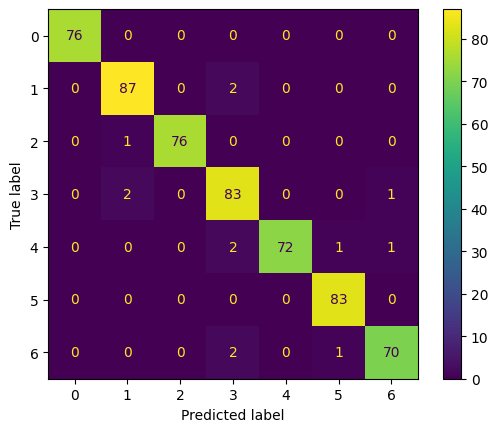

Training and Evaluating GradientBoostingClassifier
GradientBoostingClassifierAccuracy: 0.9839285714285714
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        76
           1       0.98      1.00      0.99        89
           2       0.99      0.97      0.98        77
           3       0.97      0.99      0.98        86
           4       1.00      0.96      0.98        76
           5       0.99      0.99      0.99        83
           6       0.97      0.97      0.97        73

    accuracy                           0.98       560
   macro avg       0.98      0.98      0.98       560
weighted avg       0.98      0.98      0.98       560



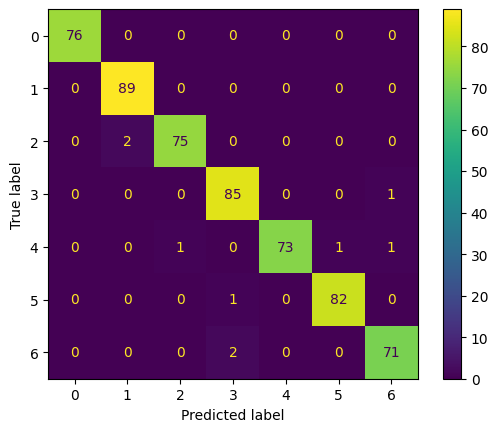

Training and Evaluating GaussianNB
GaussianNBAccuracy: 0.4732142857142857
              precision    recall  f1-score   support

           0       0.59      0.70      0.64        76
           1       0.39      0.79      0.52        89
           2       0.87      0.17      0.28        77
           3       0.27      0.27      0.27        86
           4       0.46      0.80      0.59        76
           5       0.77      0.52      0.62        83
           6       0.50      0.03      0.05        73

    accuracy                           0.47       560
   macro avg       0.55      0.47      0.42       560
weighted avg       0.54      0.47      0.43       560



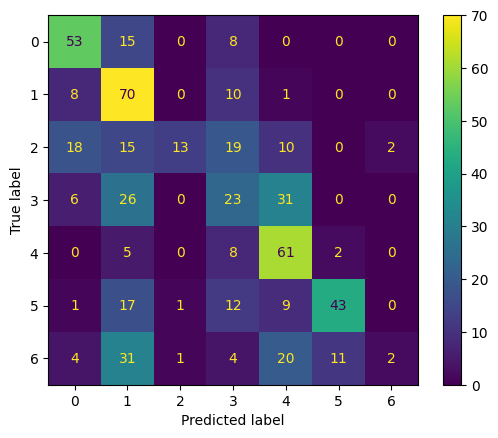

Training and Evaluating LogisticRegression


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegressionAccuracy: 0.9910714285714286
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        76
           1       0.98      0.99      0.98        89
           2       0.99      1.00      0.99        77
           3       1.00      0.98      0.99        86
           4       1.00      0.97      0.99        76
           5       0.99      1.00      0.99        83
           6       1.00      1.00      1.00        73

    accuracy                           0.99       560
   macro avg       0.99      0.99      0.99       560
weighted avg       0.99      0.99      0.99       560



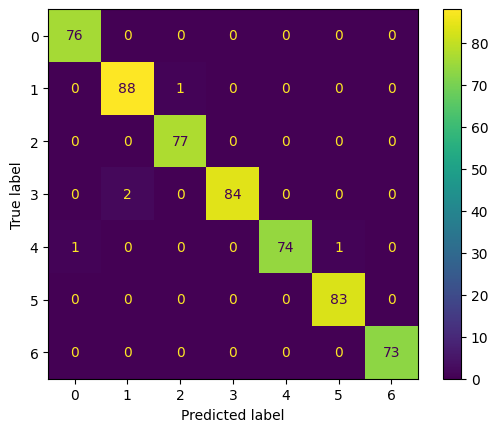

Training and Evaluating SVM-sigmoid
SVM-sigmoidAccuracy: 0.13035714285714287
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        76
           1       0.00      0.00      0.00        89
           2       0.00      0.00      0.00        77
           3       0.00      0.00      0.00        86
           4       0.00      0.00      0.00        76
           5       0.00      0.00      0.00        83
           6       0.13      1.00      0.23        73

    accuracy                           0.13       560
   macro avg       0.02      0.14      0.03       560
weighted avg       0.02      0.13      0.03       560



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


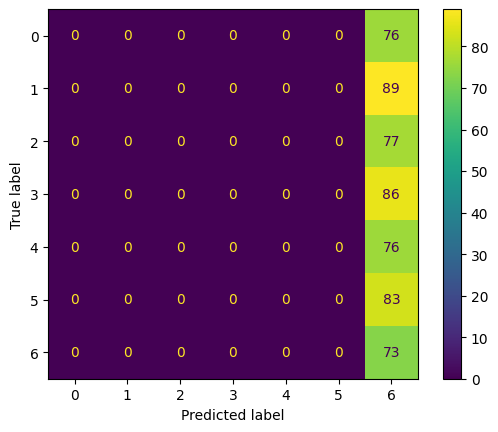

Training and Evaluating SVM-rbf
SVM-rbfAccuracy: 0.9910714285714286
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        76
           1       0.99      0.98      0.98        89
           2       1.00      1.00      1.00        77
           3       0.98      0.98      0.98        86
           4       1.00      0.99      0.99        76
           5       0.99      1.00      0.99        83
           6       0.99      1.00      0.99        73

    accuracy                           0.99       560
   macro avg       0.99      0.99      0.99       560
weighted avg       0.99      0.99      0.99       560



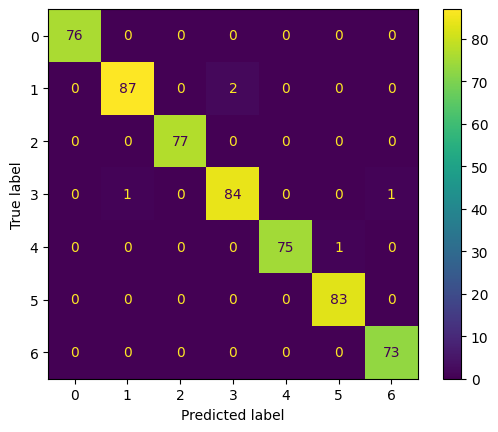

Training and Evaluating SVM-linear
SVM-linearAccuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        76
           1       1.00      1.00      1.00        89
           2       1.00      1.00      1.00        77
           3       1.00      1.00      1.00        86
           4       1.00      1.00      1.00        76
           5       1.00      1.00      1.00        83
           6       1.00      1.00      1.00        73

    accuracy                           1.00       560
   macro avg       1.00      1.00      1.00       560
weighted avg       1.00      1.00      1.00       560



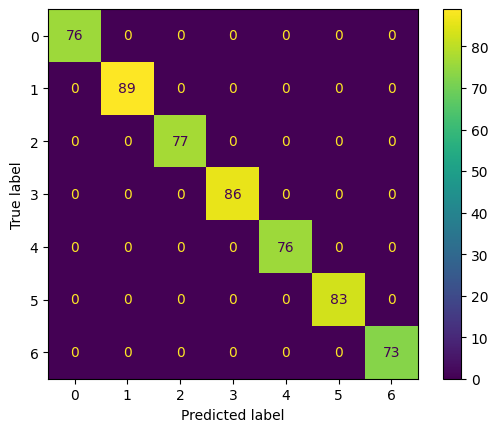

Training and Evaluating LGBMClassifier
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261375
[LightGBM] [Info] Number of data points in the train set: 2240, number of used features: 1025
[LightGBM] [Info] Start training from score -1.933488
[LightGBM] [Info] Start training from score -1.974438
[LightGBM] [Info] Start training from score -1.936579
[LightGBM] [Info] Start training from score -1.964838
[LightGBM] [Info] Start training from score -1.933488
[LightGBM] [Info] Start training from score -1.955329
[LightGBM] [Info] Start training from score -1.924271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

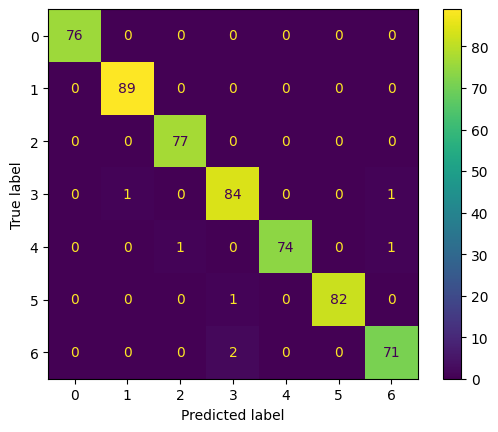

Training and Evaluating XGBClassifier
XGBClassifierAccuracy: 0.9857142857142858
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        76
           1       1.00      1.00      1.00        89
           2       0.99      1.00      0.99        77
           3       0.98      0.98      0.98        86
           4       0.97      0.96      0.97        76
           5       0.99      0.99      0.99        83
           6       0.97      0.97      0.97        73

    accuracy                           0.99       560
   macro avg       0.99      0.99      0.99       560
weighted avg       0.99      0.99      0.99       560



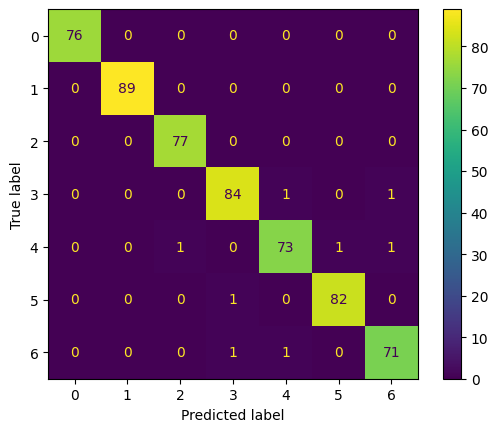

In [21]:
for clf_name,clf in classifiers.items():
  print(f"Training and Evaluating {clf_name}")
  clf.fit(X_train,y_train)
  y_pred=clf.predict(X_test)
  print(f"{clf_name}Accuracy: {accuracy_score(y_test,y_pred)}")
  print(classification_report(y_test,y_pred))
  cm=confusion_matrix(y_test,y_pred)
  disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
  disp.plot()
  plt.show()